#About the Data

* The data was taken from 
the csv file complaints.csv


* The complaints are for the products:<br>

  1. 'Bank account or service'
  2. 'Checking or savings account'
  3. 'Consumer Loan'
  4. 'Credit card or prepaid card'
  5. 'Credit reporting, credit repair services, or other personal consumer reports' 
  6. 'Debt collection'
  7. Money transfer/s, virtual currency, or money service'
  8. 'Mortgage'
  9. 'Payday loan, title loan, or personal loan'
  10. 'Student loan'
  11. 'Vehicle loan or lease'


* The data cleaning and stopwords removal was done using the spacy library

* The sample data has at most 10 percent 'MASK' words. 

#Fine Tuning DistilBERT model for text classification

* The model was trained on 5 epochs and the learning rate was set at 1e-5 and batch size 16

* Total time taken to create the dataframe with top 3 rank of predictions in the test data is : 0:17:12 (h:mm:ss)

* Data Split:<br>
      -Training data: 26787 (72 percent)
      -Validation data: 6697 (18 percent)
      -Test Data : 3721 (10 percent)

* Macro-averaged f1-score<br>
      -Training data: 0.69
      -Validation data: 0.66
      -Testing data: 0.61 

* Fine-tuning was done on the sample data of size 37205 entries

##Memory Allocated

In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

26G


##Google Drive access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Path

In [ ]:
# write the appropriate paths to retrieve the data and store results 
saved_path = '/content/drive/MyDrive/Complaints_csv/Experiment3/Upload/'
used_test_data_path = saved_path  + "Test_data_DistilBERT.csv"

## Set-up environment

Install the libraries HuggingFace Transformers and Datasets

In [ ]:
#Install HuggingFace tranformer and datasets libraries  
!pip install folium==0.2.1 -q
!pip install -q transformers datasets 

     |████████████████████████████████| 69 kB 5.2 MB/s 
     |████████████████████████████████| 4.2 MB 15.0 MB/s 
     |████████████████████████████████| 346 kB 72.2 MB/s 
     |████████████████████████████████| 6.6 MB 47.0 MB/s 
     |████████████████████████████████| 596 kB 87.0 MB/s 
     |████████████████████████████████| 86 kB 4.1 MB/s 
     |████████████████████████████████| 140 kB 81.3 MB/s 
     |████████████████████████████████| 1.1 MB 63.7 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 212 kB 71.1 MB/s 
     |████████████████████████████████| 127 kB 73.5 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
     |████████████████████████████████| 271 kB 71.1 MB/s 
     |████████████████████████████████| 144 kB 69.9 MB/s 


In [ ]:
#Check if GPU is available
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, "is available")

cpu is available


## Loading the Dataset

In [ ]:
#Load the data
import pandas as pd
test_data_df = pd.read_csv(used_test_data_path)
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3721 entries, 0 to 3720
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  3721 non-null   object
 1   label     3721 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB


Example

In [ ]:
test_data_df.loc[0,'sentence']

' debit card m hearing people order enroll travel rewards programs credit card. love travel time like travel rewards program connected bank requiring use credit card. outrageous require use credit cards enroll travel rewards programs.'

In [ ]:
test_data_df.loc[0,'label']

'Credit card or prepaid card'

In [ ]:
#Import the librarires required for the function get_top3_rank
import torch
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import logging
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW 
from transformers import pipeline
import numpy as np
import time

In [ ]:
#Create a function for formatting elapsed times as hh:mm:ss
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
#Import the librarires required for the function text_pre_process
import spacy
import re
spacy_nlp = spacy.load("en_core_web_sm")
def text_pre_process(text):
  """
  text: the user-typed input text
  the function text_pre_process outputs change_text that is the pre-processed text
  """
  #Create Spacy Doc
  text_doc = spacy_nlp(text)
  #Define the strings to mask
  mask_words_list =['XX/XX/XXXX','XX-XX-XXXX', #DATE mm/dd/yyyy mm-dd-yyyy
                          'XXXX XXXX XXXX XXXX XXXX','XXXX-XXXX-XXXX-XXXX',#CREDIT or PREPASID CARD NUMBER
                          'XXXX XXXX XXXX XXXX','XXXX XXXX XXXX','XXXX-XXXX-XXXX','XXXX-XXXX','XXXX XXXX',
                          'XXX-XX-XXXX','XXX-XXX','XX-XXXX',
                          'XXXXXXXXXXXXXXXXXX','XXXXXXXXXXXXXXXXX', 'XXXXXXXXXXXXXXXX', 'XXXXXXXXXXXXXXX', 'XXXXXXXXXXXXXX',# BANK ACCOUNT NUMBER
                          'XXXXXXXXXXXXX', 'XXXXXXXXXXXX', 'XXXXXXXXXXX',                                                   # RANGES FROM 12 TO 18 DIGITS
                          'XXXXXXXXXX','XXXXXXXXX'          #ROUTING NUMBER IS 9 DIGIT
                          'XXXX','XXX','XX']
  #Pre-process the Text
  def change_details(word):
    """
    word: is the word contained in the text_doc
    the function change_details outputs string depending on the type of the word
    """
    if word.like_email or word.like_url:
        return '<MASK>'
    elif any(mask_word in word.text for mask_word in mask_words_list):
        return '<MASK>'
    elif word.is_stop:
        return ''
    elif (len(re.findall('\.',word.text)) < 1) :
        if word.is_punct:
            return ''
    return word.text

  # Function where each token of spacy doc is passed through change_details()
  def change_text(doc):
      """
      doc: is the spacy document of the corresponding text
      the function change_text returns the preprocessed string
      """
      # Passing each token through change_details() function.
      new_tokens = map(change_details,doc)
      new_text = str(' '.join(new_tokens))
      # Replace more than one white space in the string with one white space
      new_text = re.sub(' +', ' ',new_text)
      new_text = new_text.replace(' .', '.')
      new_text = new_text.replace('\n', '')
      return new_text    
  changed_text = change_text(text_doc)
  return changed_text

In [ ]:
def get_top3_rank(df,column_name):
  """
  df: the input dataframe containg text
  column_name : the text column containg the input text
  the function get_top3_rank outputs rank_df the dataframe that contains the top 3 ranks
  """
  ############################################################################################################
  #Function to create DistilBERT pipeline
  ############################################################################################################
  def get_rank_dataframe(df,column_name):
    """
    df: the input dataframe containg text
    column_name : the text column containg the input text
    the function get_rank_dataframe returns the dataframe with top3 ranks
    """
    ############################################################################################################
    #Check if GPU is Available or not
    ############################################################################################################
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    ############################################################################################################
    #Write the appropriate paths to retrieve the data 
    ############################################################################################################
    user_path = '/content/drive/MyDrive/Complaints_csv/Experiment3/Upload/'
    best_model_path = user_path + "best_model.pt"
    label2id_df_path = user_path + "label2id_df.csv"
    ############################################################################################################
    #Create a label2id dictionary to map label and index
    ############################################################################################################
    labels2id_df = pd.read_csv(label2id_df_path)
    labels = labels2id_df.columns.to_list()
    ids = [int(i) for i in labels2id_df.loc[0,:]]
    id2label = {A: B for A, B in zip(ids, labels)} 
    label2id = {A: B for A, B in zip(labels,ids)} 
    labels = list(labels)
    ############################################################################################################
    #Load the tokenizer
    ############################################################################################################
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased',num_labels=len(labels))
    logging.set_verbosity_error()
    ############################################################################################################
    #Load the best model
    ############################################################################################################
    model_best = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)


    model_best.to(device)
    ############################################################################################################
    #SET THE PARAMETERS
    fixed_learning_rate = 1e-5
    fixed_batch_size = 16
    ############################################################################################################
    #LOAD THE OPTIMZER
    #Optimizer
    optimizer_best = AdamW(model_best.parameters(),lr = fixed_learning_rate)
    ############################################################################################################
    # The function load_chkp is created for loading model
    def load_ckp(checkpoint_fpath, model, optimizer):
      """
      checkpoint_path: path to save checkpoint
      model: model that we want to load checkpoint parameters into       
      optimizer: optimizer we defined in previous training
      """
      # load check point
      checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
      # initialize state_dict from checkpoint to model
      model.load_state_dict(checkpoint['state_dict'])
      # initialize optimizer from checkpoint to optimizer
      optimizer.load_state_dict(checkpoint['optimizer'])
      # initialize valid_loss_min from checkpoint to valid_loss_min
      valid_loss_min = checkpoint['valid_loss_min']
      # return model, optimizer, epoch value, min validation loss 
      return model, optimizer, checkpoint['epoch'], valid_loss_min

    # load the saved checkpoint
    model_best, optimizer_best, end_epoch, valid_loss_min = load_ckp(best_model_path, model_best, optimizer_best)
    ############################################################################################################
    #Get inference from the DistilBERT pipline
    ############################################################################################################  
    #set the device_value
    if device == 'cuda:0':
        device_value = 0
    else:
        device_value =-1

     #Create the DistilBERT pipeline
    MAX_LENGTH = model_best.config.max_position_embeddings
  
    distilbert_nlp = pipeline(task="sentiment-analysis", return_all_scores = True, model=model_best, tokenizer=tokenizer,
                              device= device_value, max_length = MAX_LENGTH , truncation=True)
    ############################################################################################################
    #Return the result in a data frame
    ############################################################################################################
    labels_rank_list=[]
    labels_score_list=[]
    def get_rank(example,fix_rank = 3):
      #Pre-process the example text
      example_doc =  text_pre_process(example)
      #Input the pre-processed text
      result_value = distilbert_nlp(example_doc)
      sorted_value = sorted(result_value[0], key=lambda k: k['score'],reverse = True)
      new_dictionary_label = {'predicted_label_' + str(i+1): sorted_value[i]['label'] for i in range(fix_rank)}
      new_dictionary_score = {'predicted_percentage_' + str(i+1): 100 * sorted_value[i]['score'] for i in range(fix_rank)}
      labels_rank_list.append(new_dictionary_label)
      labels_score_list.append(new_dictionary_score)
    df[column_name].map(lambda row : get_rank(row,fix_rank = 3))
    list2d_rank = {key: [i[key] for i in labels_rank_list] for key in labels_rank_list[0]}
    list2d_score = {key: [i[key] for i in labels_score_list] for key in labels_score_list[0]}
    predicted_dataframe = pd.concat([df,pd.DataFrame(list2d_rank),pd.DataFrame(list2d_score)], axis=1)
    predicted_dataframe.rename(columns = {'label':'true_label'}, inplace = True)
    return predicted_dataframe
  start_t0 = time.time()
  rank_df = get_rank_dataframe(df,column_name)
  print("\nTotal time taken to create the dataframe: {:} (h:mm:ss)".format(format_time(time.time() - start_t0)))
  return rank_df

In [ ]:
#Call the function get_top3_rank using the input test_data_df and 'sentence' column in test_data_df to return the dataframe with top 3 rank
top3_df = get_top3_rank(test_data_df,'sentence')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]


Total time taken to create the dataframe: 0:17:12 (h:mm:ss)


In [ ]:
#Display the first five entries in the data frame top3_df
top3_df.head()

,sentence,true_label,predicted_label_1,predicted_label_2,predicted_label_3,predicted_percentage_1,predicted_percentage_2,predicted_percentage_3
0,debit card m hearing people order enroll trav...,Credit card or prepaid card,Credit card or prepaid card,Bank account or service,Checking or savings account,56.837875,19.390760,16.888671
1,disputed account credit report asked removed ...,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Debt collection,Credit card or prepaid card,98.720700,1.019418,0.066798
2,lender Nationstar d b Mr. Copper. courts modi...,Mortgage,Mortgage,Debt collection,"Credit reporting, credit repair services, or o...",98.831719,0.369329,0.365157
3,Loan sold <MASK> <MASK> Nationstar <MASK> 201...,Mortgage,Mortgage,Debt collection,"Credit reporting, credit repair services, or o...",98.748118,0.418534,0.380608
4,idea company credit reports. heard insane amo...,Debt collection,Debt collection,"Credit reporting, credit repair services, or o...",Consumer Loan,96.677989,2.373028,0.215832


Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [ ]:
label2id_df_path = '/content/drive/MyDrive/Complaints_csv/Experiment3/Upload/label2id_df.csv'
labels2id_df = pd.read_csv(label2id_df_path)
labels2id_df

,Bank account or service,Checking or savings account,Consumer Loan,Credit card or prepaid card,"Credit reporting, credit repair services, or other personal consumer reports",Debt collection,"Money transfer/s, virtual currency, or money service",Mortgage,"Payday loan, title loan, or personal loan",Student loan,Vehicle loan or lease
0,0,1,2,3,4,5,6,7,8,9,10


In [ ]:
labels = labels2id_df.columns.to_list()
ids = [int(i) for i in labels2id_df.loc[0,:]]
id2label = {A: B for A, B in zip(ids, labels)} 
label2id = {A: B for A, B in zip(labels,ids)} 
labels = list(labels)

The dataset consists of 11 labels.

The confusion matrix is : 



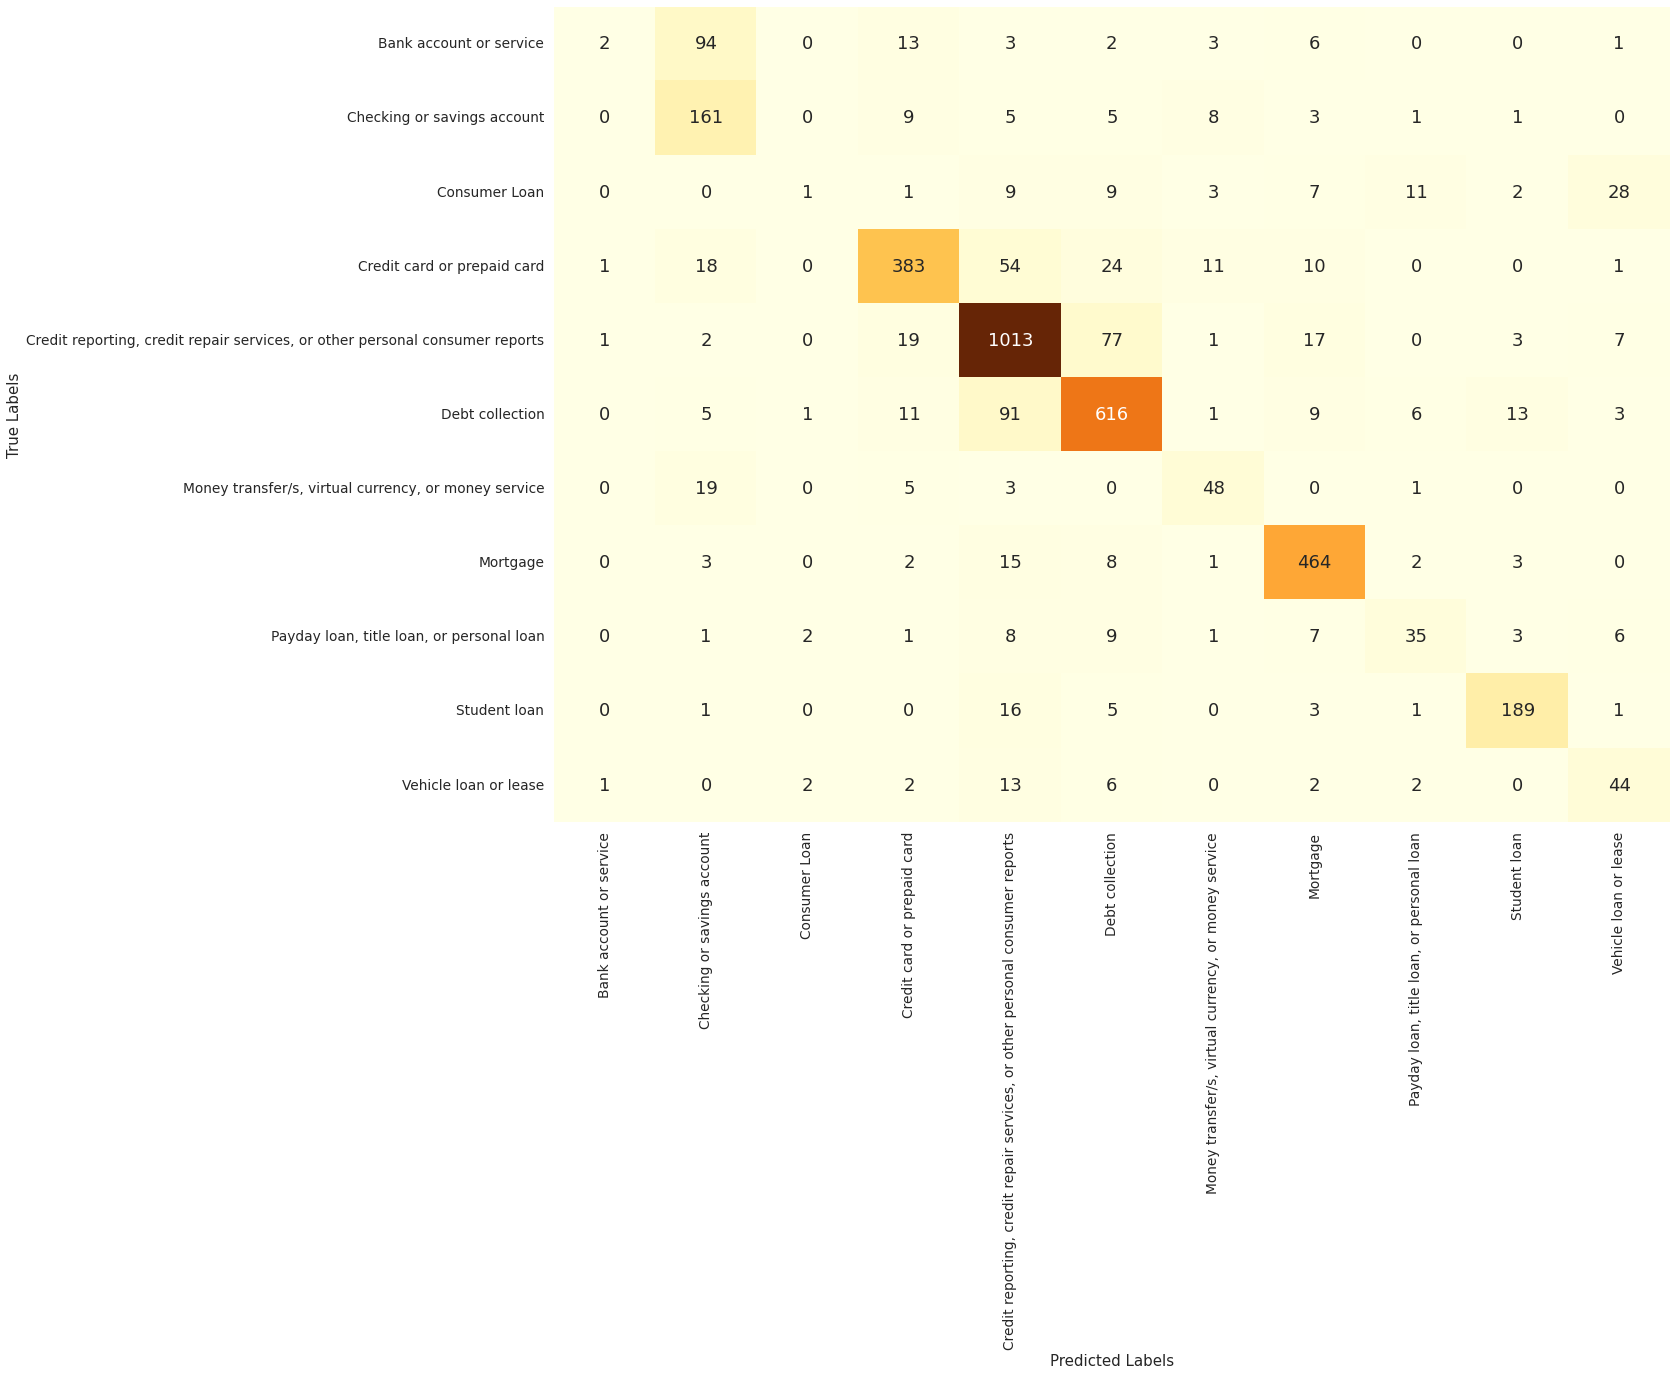

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
True_labels = top3_df["true_label"].to_list() 
Predicted_labels = top3_df["predicted_label_1"].to_list() 
cm = confusion_matrix(True_labels, Predicted_labels)
#plot the confusion matrix
print("The confusion matrix is : \n")
plt.figure(figsize=(20,15))
sns.set(font_scale=1.25)
ax =sns.heatmap(cm, annot=True, fmt='d',cbar=False,xticklabels=labels, yticklabels=labels,cmap="YlOrBr",annot_kws={"size": 18})
ax.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.show()

In [ ]:
#Display Classification Report
from sklearn.metrics import classification_report
print(classification_report(True_labels, Predicted_labels,zero_division=0))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.40      0.02      0.03       124
                                                 Checking or savings account       0.53      0.83      0.65       193
                                                               Consumer Loan       0.17      0.01      0.03        71
                                                 Credit card or prepaid card       0.86      0.76      0.81       502
Credit reporting, credit repair services, or other personal consumer reports       0.82      0.89      0.85      1140
                                                             Debt collection       0.81      0.81      0.81       756
                        Money transfer/s, virtual currency, or money service       0.62      0.63      0.63        76
                                                       

In [ ]:
# Calculate the First Prediction Percentages
top3_df["First_Prediction_Percentage"] = (top3_df["true_label"]  == top3_df['predicted_label_1']) * 100
# Calculate the First and Second Prediction Percentages
top3_df["First_and_Second_Prediction_Percentage"] = ((top3_df["true_label"]  == top3_df['predicted_label_1']) |((top3_df["true_label"]  == top3_df['predicted_label_2']))) * 100

In [ ]:
# Calculate the accuracy of First and Second Predictions
accuracy_df = top3_df.loc[:,['true_label',"First_Prediction_Percentage", "First_and_Second_Prediction_Percentage"]].groupby('true_label').mean() 
accuracy_df 

,First_Prediction_Percentage,First_and_Second_Prediction_Percentage
true_label,,
Bank account or service,1.612903,75.806452
Checking or savings account,83.419689,90.155440
Consumer Loan,1.408451,49.295775
Credit card or prepaid card,76.294821,88.645418
"Credit reporting, credit repair services, or other personal consumer reports",88.859649,98.596491
Debt collection,81.481481,94.973545
"Money transfer/s, virtual currency, or money service",63.157895,75.000000
Mortgage,93.172691,96.385542
"Payday loan, title loan, or personal loan",47.945205,61.643836
